## 1) loading all pages of PDF

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(r"nepall.pdf")

pages = []
async for page in loader.alazy_load():
    pages.append(page)

len(pages)

10

## 2) Chunking the documents

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=200,
)

chunk_texts = text_splitter.split_documents(pages)
page_contents  = [doc.page_content for doc in chunk_texts]
print(f"Total chunks: {len(page_contents)}")

Total chunks: 95


## 3) Generating Embeddings from Chunks

In [ ]:
# https://aistudio.google.com/ for api key
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001", google_api_key="") 
docs_vector = embeddings.embed_documents(page_contents)
print(f"embeddings size", len(docs_vector[0]))

embeddings size 3072


In [ ]:
embeddings.a

## 4) Creating PineCone Index

In [ ]:
import time
from pinecone import Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(
    api_key="",
    ssl_verify=False
)

# Create a serverless index
index_name = "mcp-index"

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws", 
            region="us-east-1"
        ) 
    ) 

    print("Index Created Sucessfully")
else:
    print("Index already exists")

# Wait for the index to be ready
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

Index already exists


## 5) Putting the chunks in Vector Store

In [39]:
index = pc.Index(index_name)
records = []
for i,(d,e) in enumerate(zip(page_contents ,docs_vector)):
    records.append({
        "id": f"chunk_{i}",
        "values": e,
         "metadata": {"text": d}
    })

index.upsert(
    vectors=records,
    namespace="nepal_docs"
)

UpsertResponse(upserted_count=95, _response_info={'raw_headers': {'date': 'Sat, 29 Nov 2025 14:20:10 GMT', 'content-type': 'application/json', 'content-length': '20', 'connection': 'keep-alive', 'x-pinecone-request-lsn': '1', 'x-pinecone-request-logical-size': '1210896', 'x-pinecone-request-latency-ms': '3190', 'x-pinecone-request-id': '7744635585216271862', 'x-envoy-upstream-service-time': '435', 'grpc-status': '0', 'server': 'envoy'}})

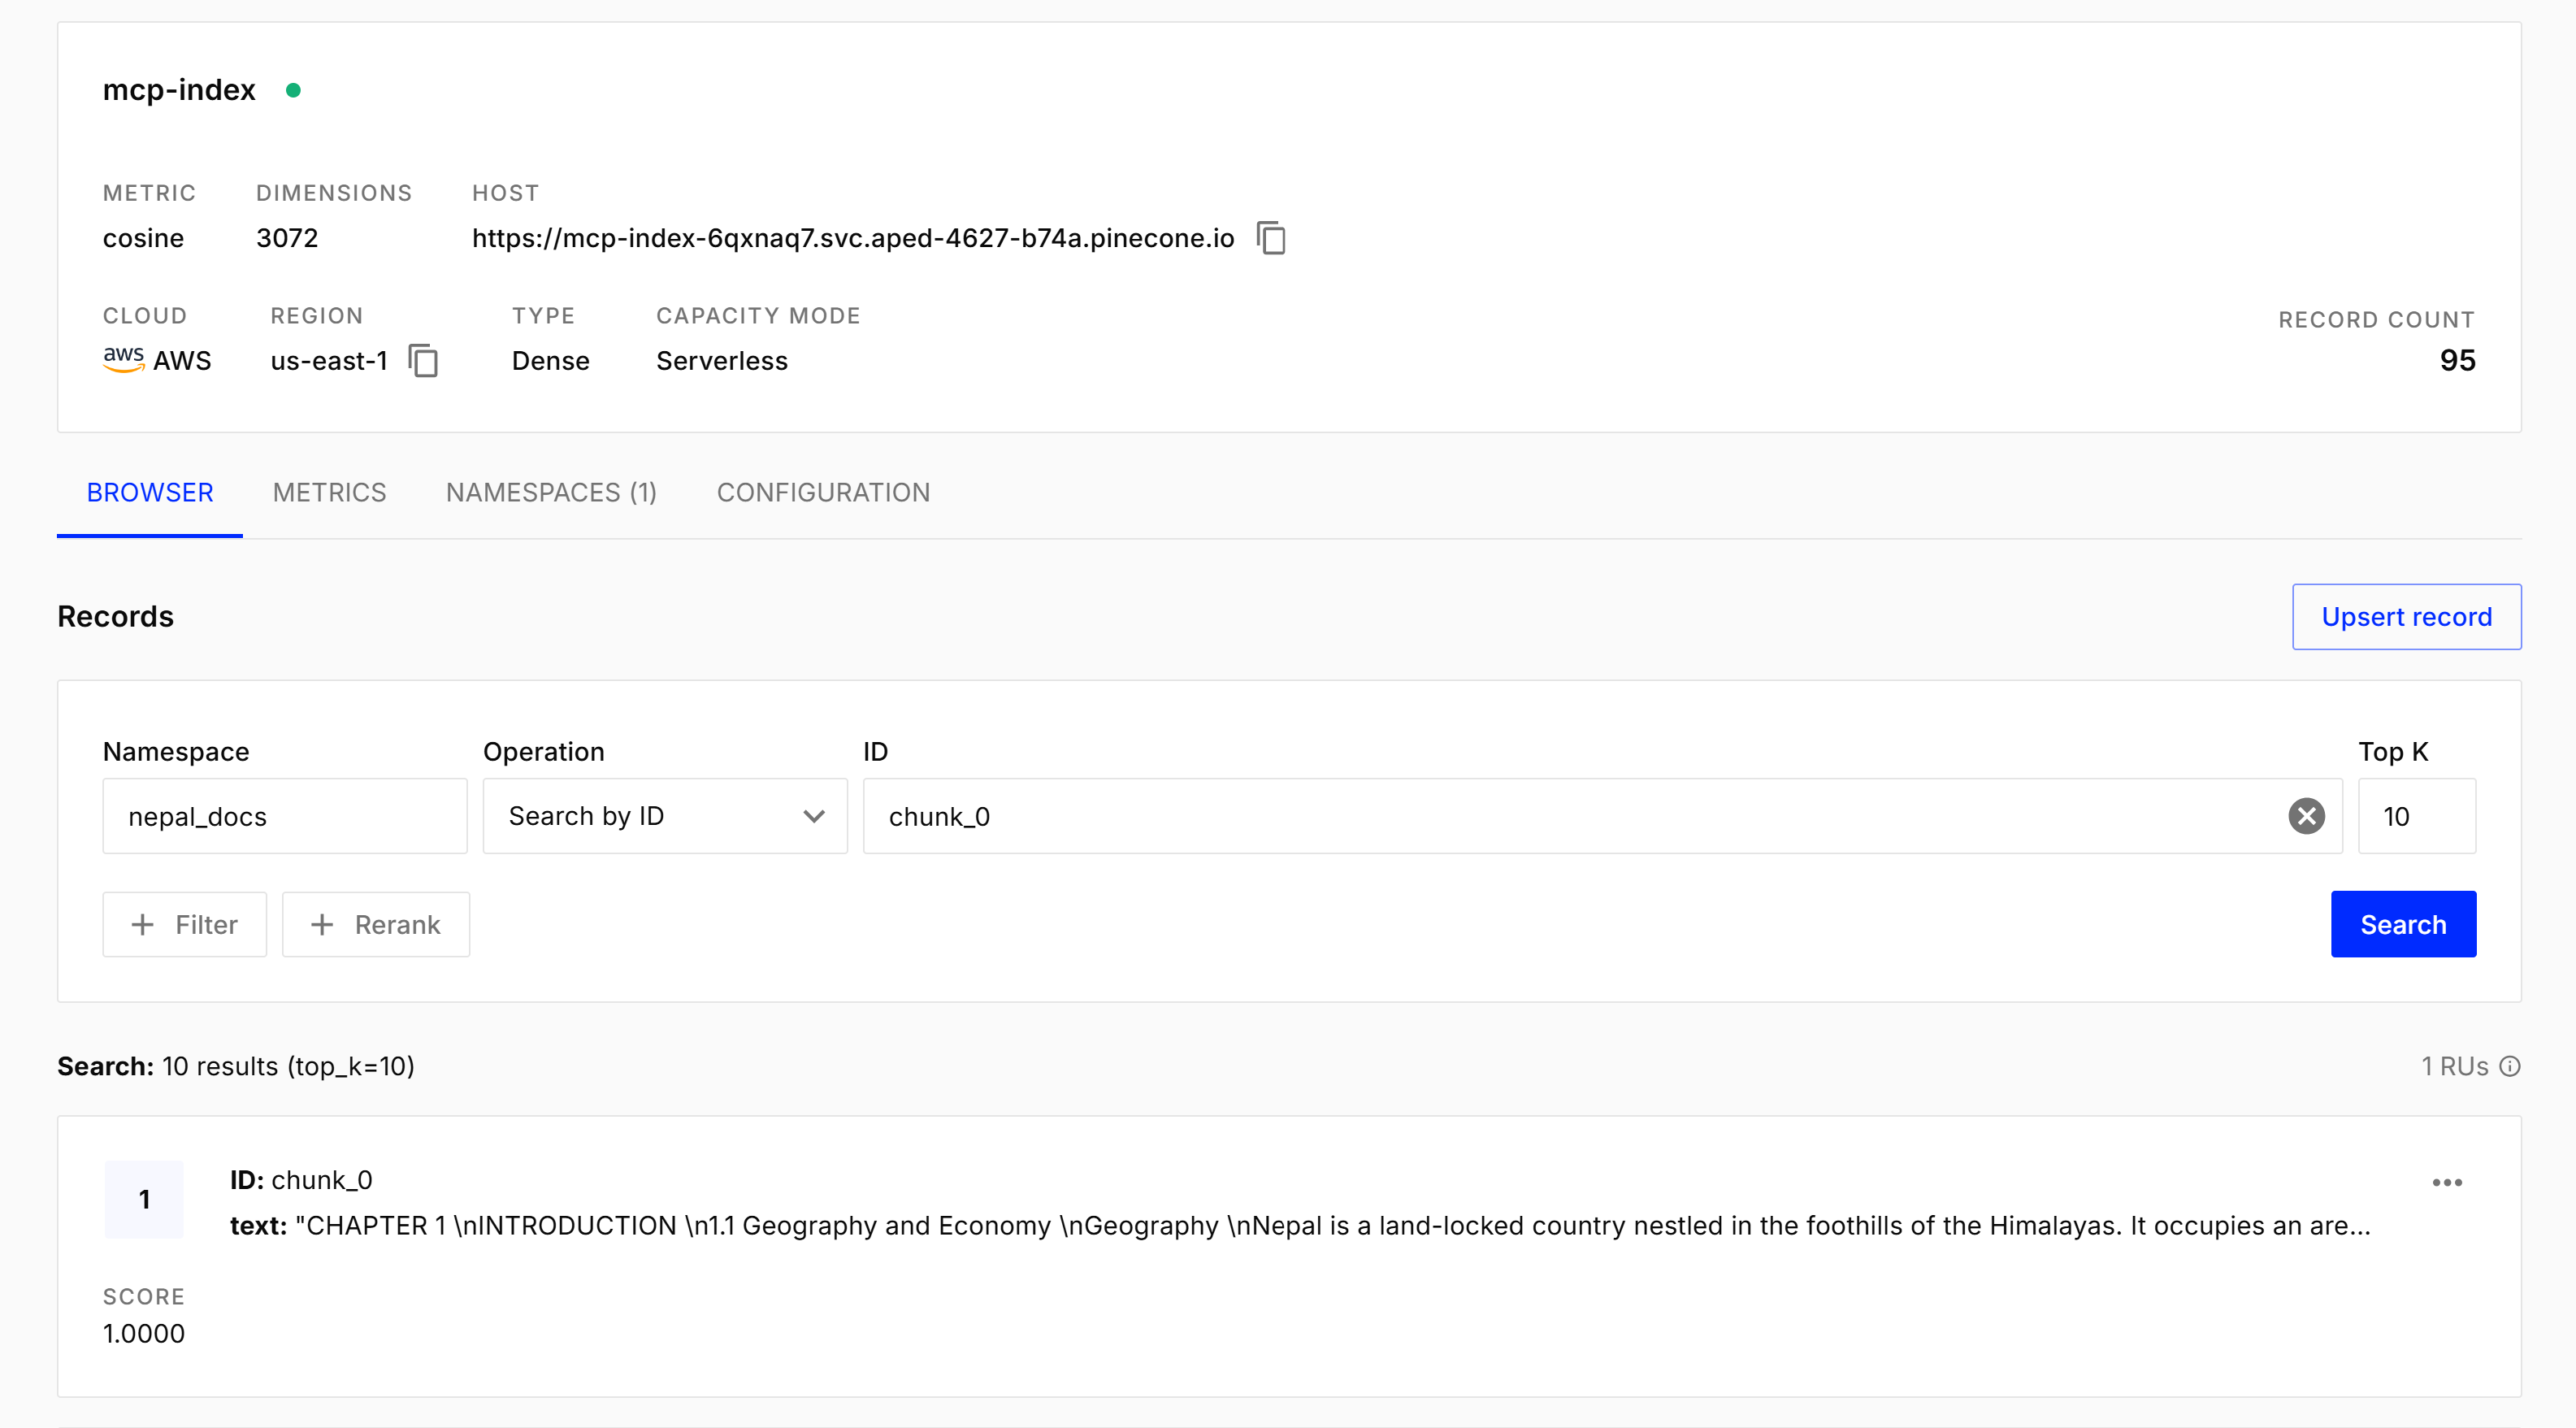

## Quering into vector store

In [2]:
index = pc.Index(index_name)

In [12]:
def query_index(pc, query: str, index_name: str, name_space: str, k: int = 5, embeddings_model=embeddings):
    
    if embeddings_model is None:
        raise ValueError("Embeddings model must be provided.")
    
    query_embeddings = embeddings_model.embed_query(query)

    if pc.has_index(index_name):
        index = pc.Index(index_name)
        pc_data = index.describe_index_stats()

        if name_space in pc_data.get('namespaces', {}):
            results = index.query(
                namespace=name_space,
                vector=query_embeddings,
                top_k=k,
                include_values=False,
                include_metadata=True
            )
            return "\n\n".join([match['metadata']['text'] for match in results.matches])
    return None

In [13]:
question="By what percentage did Nepal’s population increase over the 20-year period from 1971 to 1991?"

ans = query_index(pc=pc, query=question, index_name=index_name, name_space="nepal_docs")

In [14]:
ans

"20-year period. The population growth rate increased from 2.1 in 1971 to 2.6 in 1981 and then declined again \nto 2.1 in 1991. Nepal's population is young, with two of five persons below the age of 15. This young age \ndistribution is due to the relatively high fertility in Nepal. In fact, between 1971 and 1981 there was no change \nin the total fertility rate (TFR) obtained from census estimates. The TFR continues to be high, 5.6 percent in\n\npercent decline between 1971 and 1991. These trends suggest that the demographic transition is taking place in \nNepal with ample scope for both fertility and mortality to decline further. Male and female life expectancy has \ngone up by about 13 years over the 20-year period. \n2\n\nTable l.l Demographic indicators \nSelected demographic indicators for Nepal, 1971-1991 \nIndicator 1971 1981 \nPopulation (millions) 11.6 15.0 \nAge \n0-14 40.5 41.4 \n15-64 56.4 55.4 \n65+ 3.1 3.2 \nPopulation density \n(per square kin) 79 102 \nPercent urban 4.0